## third attempt using lewis code

Ramp rates (MW/hour): {3: array([14.99989437]), 4: array([9.99991846]), 5: array([50.00747873])}

--- Iteration 1 ---
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 28 05:52:02 PM: Your problem has 840 variables, 101130 constraints, and 0 parameters.
(CVXPY) Jan 28 05:52:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 28 05:52:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 28 05:52:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 28 05:52:02 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
----------------------------

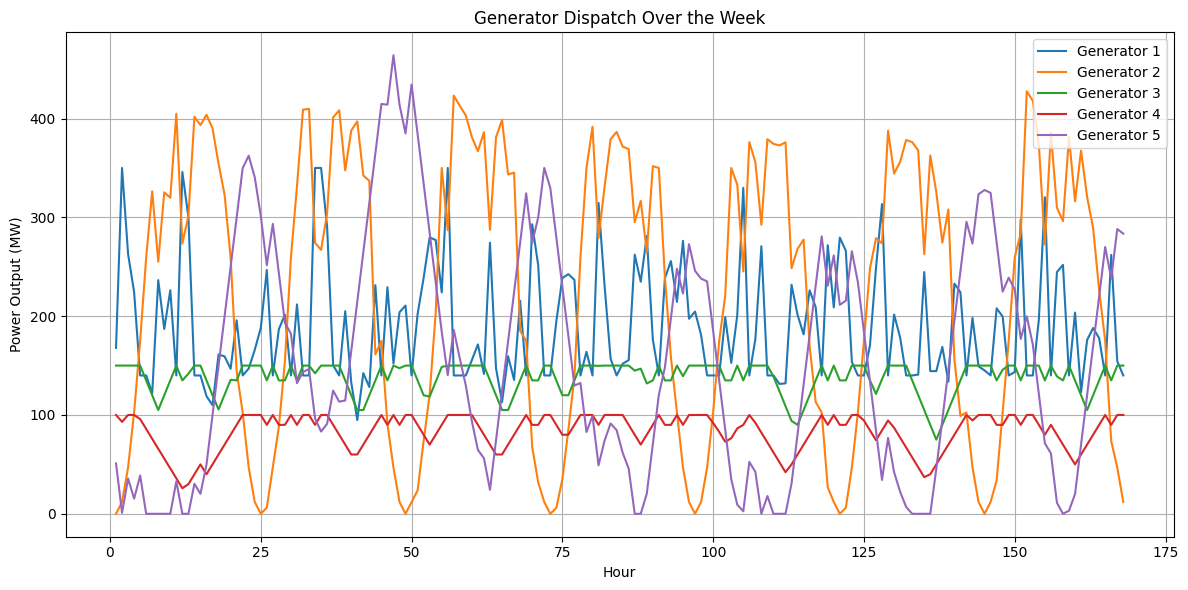

Hours where demand exceeds supply: []


In [7]:
# SOLVER WITH WIND, SOLAR AND RAMPING CONSTRAINTS

import pandas as pd
import numpy as np
import cvxpy as cp
from ddeint import ddeint
import matplotlib.pyplot as plt


#  ALL FUNCTIONS DEFINED FIRST
# -------------------------------------------------------------------------------------------------------
# FUNCTION TO SOLVE DDE AND DETERMINE RAMP RATES
def simulate_dde(tau, delay, P_initial, P_target, duration=10, steps=1000):
    """
    Simulates a generator's ramping response using a delay differential equation (DDE).
    Args:
        tau: Time constant for the generator.
        delay: Time delay before response begins.
        P_initial: Initial power output (MW).
        P_target: Target power output (MW).
        duration: Total simulation time (hours).
        steps: Number of time steps for simulation.
    Returns:
        ramp_rate: Approximate ramp rate (MW/hour).
    """
    time = np.linspace(0, duration, steps)

    # Define the DDE model
    def model(P, t):
        return (P_target - P(t - delay)) / tau

    # Define the history function
    def history(t):
        return P_initial

    # Solve the DDE
    response = ddeint(model, history, time)

    # Approximate ramp rate as the slope over the simulation period
    ramp_rate = (response[-1] - response[0]) / duration
    return abs(ramp_rate)  # Return the absolute value of ramp rate
# -------------------------------------------------------------------------------------------------------


# Function for carrying out the optimisation
def run_optimization(line_ratings_vector):
    # DECISION VARIABLES: q_supply - power supply from each generator for each hour (5x168)
    q_supply = cp.Variable((len(gen_IDs), len(node_demands)), nonneg=True)  # (MW)

    # OBJECTIVE FUNCTION - minimise total dispatch costs
    objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply)))

    # CONSTRAINTS
    constraints = []

    # (1) - Total hourly generation must equal the total hourly demand
    constraints.append(cp.sum(q_supply, axis=0) == cp.sum(node_demands.values.T, axis=0))

    # (2) - Line flow constraints
    net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T
    PF = shift_factor_matrix.values @ net_injections

    finite_mask = np.isfinite(line_ratings.values.flatten())
    constraints += [
        PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
        PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None],
    ]

    # (3) - Generator capacity constraints with hourly availability
    constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]

    # (4) - Ensure remaining demand is met by Generators 3, 4, and 5
    remaining_demand = cp.sum(node_demands.values.T, axis=0) - cp.sum(q_supply[:2, :], axis=0)
    constraints.append(cp.sum(q_supply[2:, :], axis=0) >= remaining_demand)

    # (5) - Capacity constraints for Generators 3, 4, and 5
    constraints += [q_supply[2:, :] <= gen_capacities[2:, None]]

    
    # (6) - Ramping constraints for Generators 3, 4, and 5
    for t in range(1, hours):
        for g, ramp_rate in ramp_rates.items():
            gen_idx = g - 1  # Adjust for zero-based indexing
            constraints.append(q_supply[gen_idx, t] - q_supply[gen_idx, t - 1] <= ramp_rate)
            constraints.append(q_supply[gen_idx, t - 1] - q_supply[gen_idx, t] <= ramp_rate)
    
    # SOLVE THE OPTIMISATION PROBLEM
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=True, solver=cp.ECOS)
    
    # results
    if problem.status == cp.OPTIMAL:
        q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)
        # print("Optimal generator dispatch (MW):")
        # print(q_supply_table)
        return problem.value, q_supply_table, PF.value
    else:
        raise RuntimeError("No optimal solution found!")
#-------------------------------------------------------------------------------------------------------


# Function to calculate line utilization and identify bottlenecks
def calculate_utilization(PF_values, line_ratings_vector):
    finite_mask = np.isfinite(line_ratings_vector)  # consider only finite-rated lines
    
    # Calculate utilization (percentage of transmission line power limits)
    utilization = (np.abs(PF_values[finite_mask]) / line_ratings_vector[finite_mask][:, None] * 100)
    
    # Calculate max and average utilization per line
    max_utilization = np.max(utilization, axis=1)
    avg_utilization = np.mean(utilization, axis=1)
    # Create summary table
    line_analysis = pd.DataFrame({
        "Max Utilization (%)": max_utilization,
        "Avg Utilization (%)": avg_utilization,
    }, index=shift_factor_matrix.index[finite_mask])
    
    line_analysis = line_analysis.sort_values(by="Max Utilization (%)", ascending=False) # order table so bottlenecks at top
    
    # Identify bottleneck lines (max utilization >= 100%)
    bottleneck_lines = line_analysis[line_analysis["Max Utilization (%)"] >= 100]
    
    print("\nLine Utilization Summary:")
    print(line_analysis)
    print("\nBottleneck Lines:")
    print(bottleneck_lines)
    
    return line_analysis, bottleneck_lines
#-------------------------------------------------------------------------------------------------------


# Function to adjust line ratings for bottleneck lines
def adjust_line_ratings(line_ratings_vector, bottleneck_lines):
    new_ratings = line_ratings_vector.copy()
    for line_id in bottleneck_lines.index:
        idx = np.where(shift_factor_matrix.index == line_id)[0][0]  # find index of each bottleneck line
        new_ratings[idx] *= 1.10  # increase limit by 10%
        
    return new_ratings
#-------------------------------------------------------------------------------------------------------


# Main workflow
def resolve_bottlenecks(line_ratings_vector, max_iterations=1):
    """
    Resolves bottlenecks in a network by iteratively optimizing line ratings.
    
    Parameters:
        line_ratings_vector (np.array): Initial line ratings.
        max_iterations (int): Maximum number of iterations to attempt optimization.
    
    Returns:
        tuple or None: (dispatch_cost, q_supply_table, PF_values) if successful; None if no solution is found.
    """
    for iteration in range(max_iterations):
        print(f"\n--- Iteration {iteration + 1} ---")
        
        # Step 1: Run optimization
        try:
            dispatch_cost, q_supply_table, PF_values = run_optimization(line_ratings_vector)
        except RuntimeError as e:
            print(f"Optimization failed: {e}")
            print("Optimization failed or no valid solution found")
            return None, None, None 
        
        # Step 2: Calculate utilization and identify bottlenecks
        _, bottleneck_lines = calculate_utilization(PF_values, line_ratings_vector)
                
        # If no bottlenecks, optimization is complete
        if bottleneck_lines.empty:
            print("\nNo bottlenecks detected. Optimization complete.")
            print(f"Final Dispatch Cost: £{dispatch_cost:.2f}")
            print("Optimal generator dispatch (MW):")
            print(q_supply_table)
            return dispatch_cost, q_supply_table, PF_values
        
        # Step 3: Adjust line ratings for bottleneck lines
        line_ratings_vector = adjust_line_ratings(line_ratings_vector, bottleneck_lines)
        
        # Print updated line ratings for bottleneck lines
        print("\nUpdated line ratings for bottleneck lines:")
        for line_id in bottleneck_lines.index:
            idx = np.where(shift_factor_matrix.index == line_id)[0][0]  # find index of each bottleneck line
            print(f"Line {line_id}: New Rating = {line_ratings_vector[idx]:.2f}")
    
    # If max iterations are reached without resolving bottlenecks
    print("\nMax iterations reached. Returning most recent solution with bottlenecks.")
    print(f"Final Dispatch Cost: £{dispatch_cost:.2f}")
    print("Optimal generator dispatch (MW):")
    print(q_supply_table)
    
    return dispatch_cost, q_supply_table, PF_values
#-------------------------------------------------------------------------------------------------------


# START OF MAIN CODE BLOCK

# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0) # 168 hours by 20 demand nodes
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0) # Have lINE_ID as row index of the dataframe
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0) # 532x1 vector


# EXTRACT REQUIRED INFO FROM INPUT DATA
gen_IDs = np.array( generator_data.loc[:, "NODE"].astype(int) )
gen_marginal_costs = np.array( generator_data.loc[:, "MC"] ) # (£/MWh) 
gen_capacities = np.array( generator_data.loc[:, "CAP"] ) # (MW)
gen_capacities[1] *= 2  # Double the capacity of Generator 2 (Solar)

demand_IDs = np.array(node_demands.columns.astype(int))
node_IDs = np.array(shift_factor_matrix.columns.astype(int))


# GENERATOR AND DEMAND CONTRIBUTIONS AS MATRICES
# Generator contributions
gen_indices = {g_ID: np.where(node_IDs == g_ID)[0][0] for g_ID in gen_IDs}  # indices of generators in node_IDs
gen_identity_mat = np.zeros((len(node_IDs), len(gen_IDs))) # (428,5)
gen_identity_mat[list(gen_indices.values()), np.arange(len(gen_IDs))] = 1 # Mark each generator for each column as a 1

# Demand contributions
demand_indices = {d_ID: np.where(node_IDs == d_ID)[0][0] for d_ID in demand_IDs}  # indices of demands in node_IDs
demand_identity_mat = np.zeros((len(node_IDs), len(demand_IDs))) # (428,20)
demand_identity_mat[list(demand_indices.values()), np.arange(len(demand_IDs))] = 1 # Mark each demand node for each column as a 1


# HOURLY AVAILABILITY FOR GENERATORS 1 AND 2
hours = node_demands.shape[0]
time = np.arange(hours)
# Solar availability as a sine wave (Generator 2)
solar_availability = 0.5 * (1 + np.sin(2 * np.pi * time / 24 - np.pi / 2))  # Sine wave shifted to make nighttime 0
solar_availability = np.clip(solar_availability, 0, 1)  # Ensure values are between 0 and 1

# Generate Weibull-distributed wind availability
np.random.seed(42)  # Replace 42 with any integer of your choice
shape, scale = 2.3, 9.5  # Example Weibull parameters
wind_availability_gen1 = np.random.weibull(shape, hours) * scale
wind_availability_gen2 = np.random.weibull(shape, hours) * scale

max_possible_speed = scale * 1.5  # Assume maximum wind speed reaches ~1.5x scale
wind_availability_gen1 = np.clip(wind_availability_gen1 / max_possible_speed, 0.4, 1.0) # Ensure at least 40% availability
wind_availability_gen2 = np.clip(wind_availability_gen2 / max_possible_speed, 0.4, 1.0) # Ensure at least 40% availability

# Create the availability matrix
availability_matrix = np.ones((len(gen_IDs), hours))
availability_matrix[0, :] = wind_availability_gen1 # Generator 1 (solar)
availability_matrix[1, :] = solar_availability  # Generator 2 (wind)


# DETERMINE RAMP RATES FOR GENERATORS 3, 4 AND 5
ramp_rates = {}
for gen_id, tau, delay, P_initial, P_target in zip(
    [3, 4, 5], [1.6, 1.7, 2.5], [0.55, 0.6, 1.0], [0, 0, 0], [gen_capacities[2], gen_capacities[3], gen_capacities[4]]
):
    ramp_rates[gen_id] = simulate_dde(tau, delay, P_initial, P_target)
print("Ramp rates (MW/hour):", ramp_rates)


line_ratings_vector = line_ratings.values.flatten()
dispatch_cost, q_supply_table, PF_values = resolve_bottlenecks(line_ratings_vector)

if dispatch_cost is not None:
    # PLOT THE DISPATCH FROM GENERATORS OVER THE WEEK
    plt.figure(figsize=(12, 6))
    for g in range(len(gen_IDs)):
        plt.plot(q_supply_table.iloc[g, :], label=f"Generator {g+1}")
    plt.xlabel("Hour")
    plt.ylabel("Power Output (MW)")
    plt.title("Generator Dispatch Over the Week")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# CAN USE THESE LINES OF CODE TO FIND OUT IF DEMAND > SUPPLY AT ANY HOUR - LEADS TO INFEASIBLE PROBLEM

total_demand_per_hour = np.sum(node_demands, axis=1).to_numpy(dtype=np.float64)
total_supply_per_hour = np.sum(availability_matrix * gen_capacities[:,None], axis=0)
hours_exceeding_demand = np.where(total_demand_per_hour > total_supply_per_hour)[0]
print("Hours where demand exceeds supply:", hours_exceeding_demand)


## analysing storage from this combination

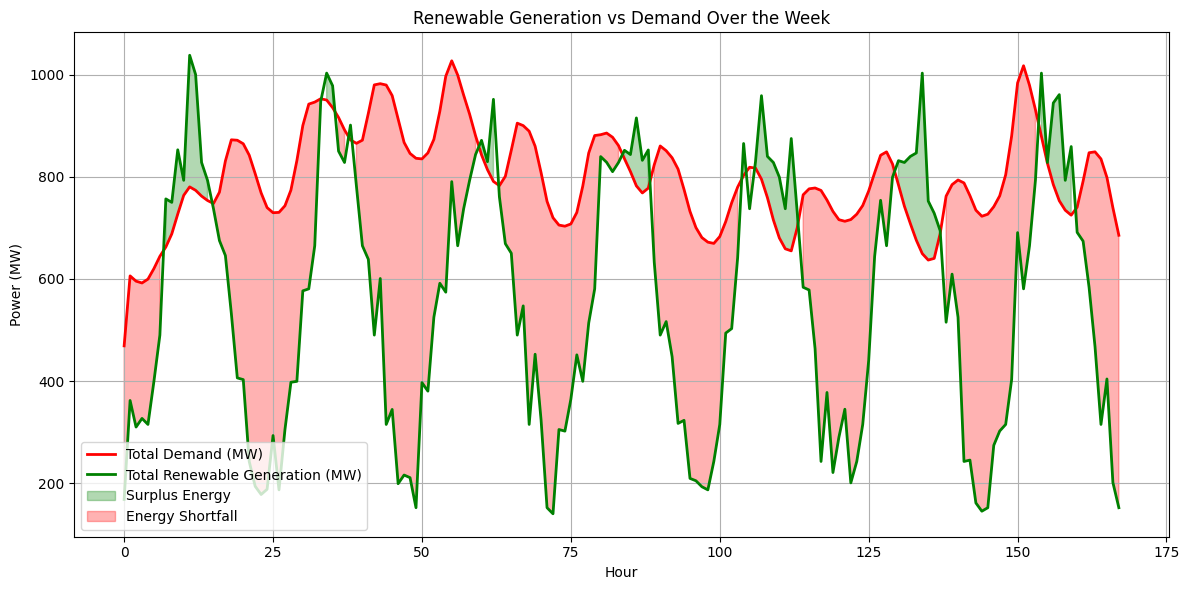

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# INPUT DATA
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)

# EXTRACT REQUIRED INFO
hours = node_demands.shape[0]
total_demand = np.sum(node_demands.values, axis=1)  # Total demand for each hour

# GENERATOR CAPACITIES (DOUBLE SOLAR GENERATOR 2)
gen_capacities = [350, 700]  # Example capacities: [Generator 1 (Wind), Generator 2 (Solar)]

# HOURLY AVAILABILITY
time = np.arange(hours)

# Solar availability as a sine wave (Generator 2)
solar_availability = 0.5 * (1 + np.sin(2 * np.pi * time / 24 - np.pi / 2))  # Sine wave shifted to make nighttime 0
solar_availability = np.clip(solar_availability, 0, 1)

# Wind availability as a Weibull distribution (Generator 1)
np.random.seed(42)
shape, scale = 2.3, 9.5
wind_availability = np.random.weibull(shape, hours) * scale
max_possible_speed = scale * 1.5
wind_availability = np.clip(wind_availability / max_possible_speed, 0.4, 1.0)  # Ensure at least 40% availability

# CALCULATE TOTAL RENEWABLE GENERATION
wind_generation = gen_capacities[0] * wind_availability
solar_generation = gen_capacities[1] * solar_availability
total_renewable_generation = wind_generation + solar_generation

# PLOT RESULTS
plt.figure(figsize=(12, 6))
plt.plot(total_demand, label="Total Demand (MW)", color="red", linewidth=2)
plt.plot(total_renewable_generation, label="Total Renewable Generation (MW)", color="green", linewidth=2)
plt.fill_between(range(hours), total_renewable_generation, total_demand, where=(total_renewable_generation >= total_demand),
                 color="green", alpha=0.3, label="Surplus Energy")
plt.fill_between(range(hours), total_renewable_generation, total_demand, where=(total_renewable_generation < total_demand),
                 color="red", alpha=0.3, label="Energy Shortfall")
plt.xlabel("Hour")
plt.ylabel("Power (MW)")
plt.title("Renewable Generation vs Demand Over the Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## storage including line constraints

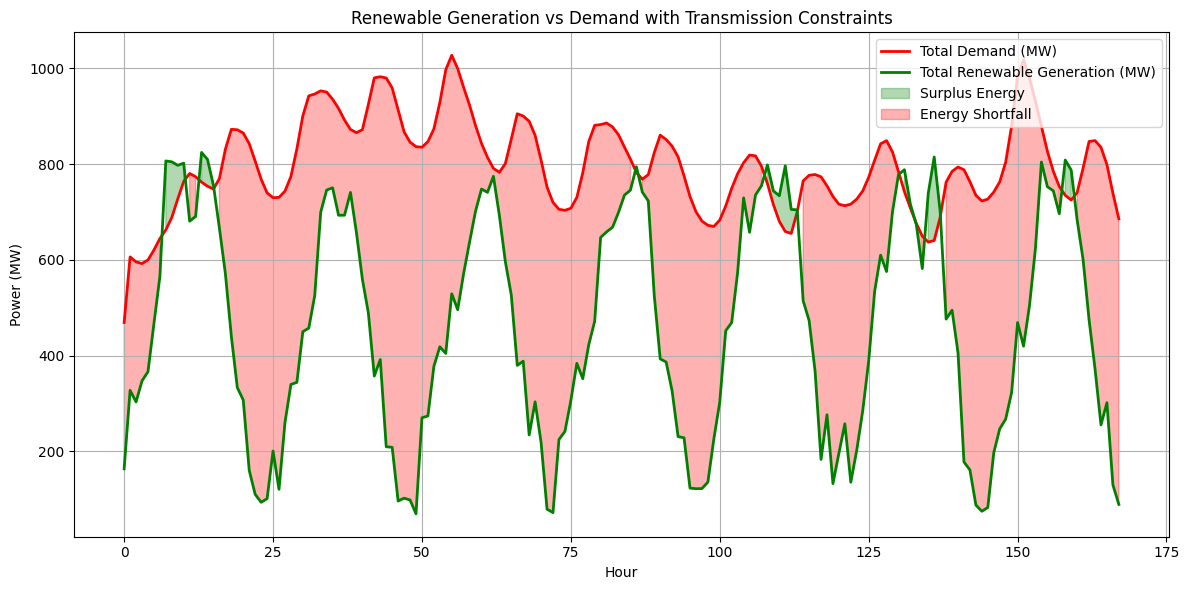

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# INPUT DATA
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0)
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0)

# EXTRACT REQUIRED INFO
hours = node_demands.shape[0]
total_demand = np.sum(node_demands.values, axis=1)  # Total demand for each hour
line_ratings_vector = line_ratings.values.flatten()  # Line rating limits (MW)

# GENERATOR CAPACITIES (TRIPLE SOLAR GENERATOR 2)
gen_capacities = [350, 1050]  # Example capacities: [Generator 1 (Wind), Generator 2 (Solar)]

# HOURLY AVAILABILITY
time = np.arange(hours)

# Solar availability as a sine wave (Generator 2)
solar_availability = 0.5 * (1 + np.sin(2 * np.pi * time / 24 - np.pi / 2))  # Sine wave shifted to make nighttime 0
solar_availability = np.clip(solar_availability, 0, 1)

# Wind availability as a Weibull distribution (Generator 1)
np.random.seed(42)
shape, scale = 2.3, 9.5
wind_availability = np.random.weibull(shape, hours) * scale
max_possible_speed = scale * 1.5
wind_availability = np.clip(wind_availability / max_possible_speed, 0.4, 1.0)  # Ensure at least 40% availability

# GENERATE TOTAL GENERATION MATRIX FOR ALL NODES (428 NODES)
total_generation = np.zeros((shift_factor_matrix.shape[1], hours))  # Initialize generation matrix (428 nodes)
node_ids = node_demands.columns.astype(int)  # Demand node IDs

# Map node IDs to their row indices in total_generation
node_to_index = {node_id: idx for idx, node_id in enumerate(shift_factor_matrix.columns.astype(int))}

# Distribute wind generation across the first 10 nodes
for i in range(10):
    if node_ids[i] in node_to_index:  # Ensure the node exists in total_generation
        total_generation[node_to_index[node_ids[i]], :] = wind_availability * gen_capacities[0] / 10

# Distribute solar generation across the next 10 nodes
for i in range(10, 20):
    if node_ids[i] in node_to_index:  # Ensure the node exists in total_generation
        total_generation[node_to_index[node_ids[i]], :] = solar_availability * gen_capacities[1] / 10

# NET INJECTIONS AT EACH NODE (428x168)
net_injections = total_generation - np.pad(node_demands.values.T, ((0, shift_factor_matrix.shape[1] - 20), (0, 0)))

# POWER FLOWS THROUGH LINES
PF = shift_factor_matrix.values @ net_injections  # Power flows on each line
finite_mask = np.isfinite(line_ratings_vector)  # Consider only lines with finite ratings
line_utilization = np.abs(PF[finite_mask]) / line_ratings_vector[finite_mask][:, None]  # Utilization as fraction of line ratings

# CONSTRAIN RENEWABLE GENERATION BY LINE RATINGS
for t in range(hours):
    overloaded_lines = np.where(line_utilization[:, t] > 1)[0]  # Identify overloaded lines
    if overloaded_lines.size > 0:
        # Scale down renewable generation to relieve overloaded lines
        scaling_factor = 1 / np.max(line_utilization[overloaded_lines, t])
        total_generation[:, t] *= scaling_factor

# RE-CALCULATE TOTAL RENEWABLE GENERATION
total_renewable_generation = np.sum(total_generation, axis=0)

# PLOT RESULTS
plt.figure(figsize=(12, 6))
plt.plot(total_demand, label="Total Demand (MW)", color="red", linewidth=2)
plt.plot(total_renewable_generation, label="Total Renewable Generation (MW)", color="green", linewidth=2)
plt.fill_between(range(hours), total_renewable_generation, total_demand, where=(total_renewable_generation >= total_demand),
                 color="green", alpha=0.3, label="Surplus Energy")
plt.fill_between(range(hours), total_renewable_generation, total_demand, where=(total_renewable_generation < total_demand),
                 color="red", alpha=0.3, label="Energy Shortfall")
plt.xlabel("Hour")
plt.ylabel("Power (MW)")
plt.title("Renewable Generation vs Demand with Transmission Constraints")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## checking fesability against cost of construction

In [36]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # INPUT DATA
# node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)
# hours = node_demands.shape[0]
# total_demand = np.sum(node_demands.values, axis=1)  # Total demand for each hour

# # Initial generator capacities
# initial_solar_capacity = 350  # MW
# wind_capacity = 350  # MW
# gen_capacities = [wind_capacity, initial_solar_capacity]

# # Marginal cost of coal/gas generation (approximation)
# fossil_fuel_marginal_cost = 216  # £/MWh

# # Solar and Wind Availability
# time = np.arange(hours)
# solar_availability = 0.5 * (1 + np.sin(2 * np.pi * time / 24 - np.pi / 2))
# solar_availability = np.clip(solar_availability, 0, 1)

# np.random.seed(42)
# shape, scale = 2.3, 9.5
# wind_availability = np.random.weibull(shape, hours) * scale
# max_possible_speed = scale * 1.5
# wind_availability = np.clip(wind_availability / max_possible_speed, 0.4, 1.0)

# # Expansion levels
# expansion_levels = range(1, 6)  # Doubling, tripling, etc., up to 5x initial capacity
# construction_cost_per_mw = 750_000  # £750,000 per MW
# savings = []
# construction_costs = []

# for multiplier in expansion_levels:
#     # Updated solar capacity
#     solar_capacity = initial_solar_capacity * multiplier
#     gen_capacities[1] = solar_capacity
    
#     # Renewable generation
#     wind_generation = wind_capacity * wind_availability
#     solar_generation = solar_capacity * solar_availability
#     total_renewable_generation = wind_generation + solar_generation
    
#     # Surplus energy
#     surplus_energy = np.maximum(total_renewable_generation - total_demand, 0)  # Surplus in MW
#     total_surplus_energy_mwh = np.sum(surplus_energy)  # Convert to MWh for the week
    
#     # Debug surplus calculation
#     print(f"Multiplier: {multiplier}")
#     print(f"Total Renewable Generation: {np.sum(total_renewable_generation):.2f} MW")
#     print(f"Total Demand: {np.sum(total_demand):.2f} MW")
#     print(f"Surplus Energy (MWh): {total_surplus_energy_mwh:.2f}")
    
#     # Savings from surplus energy
#     surplus_savings = total_surplus_energy_mwh * fossil_fuel_marginal_cost
#     savings.append(surplus_savings)
    
#     # Construction cost for the solar farm
#     solar_construction_cost = solar_capacity * construction_cost_per_mw
#     construction_costs.append(solar_construction_cost)

# # Plot Savings vs. Costs
# plt.figure(figsize=(12, 6))
# plt.plot(expansion_levels, savings, label="Savings (£)", marker="o", color="green")
# plt.plot(expansion_levels, construction_costs, label="Construction Cost (£)", marker="o", color="red")
# plt.axvline(
#     x=expansion_levels[np.argmax(np.array(savings) >= np.array(construction_costs))],
#     color="blue",
#     linestyle="--",
#     label="Optimal Expansion Point",
# )
# plt.xlabel("Solar Farm Multiplier (x Initial Capacity)")
# plt.ylabel("Cost (£)")
# plt.title("Feasibility of Solar Farm Expansion")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# import matplotlib.pyplot as plt

# # Plot Savings Only
# plt.figure(figsize=(12, 6))
# plt.plot(expansion_levels, savings, label="Savings (£)", marker="o", color="green")
# plt.xlabel("Solar Farm Multiplier (x Initial Capacity)")
# plt.ylabel("Savings (£)")
# plt.title("Savings from Solar Farm Expansion")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


# print(savings)


## adding in cost of storage

Multiplier: 2
Total Renewable Generation: 93983.59 MW
Total Demand: 133848.28 MW
Surplus Energy (MWh): 4118.25
Multiplier: 3
Total Renewable Generation: 123383.59 MW
Total Demand: 133848.28 MW
Surplus Energy (MWh): 22367.43
Multiplier: 4
Total Renewable Generation: 152783.59 MW
Total Demand: 133848.28 MW
Surplus Energy (MWh): 45631.49
Multiplier: 5
Total Renewable Generation: 182183.59 MW
Total Demand: 133848.28 MW
Surplus Energy (MWh): 71303.59


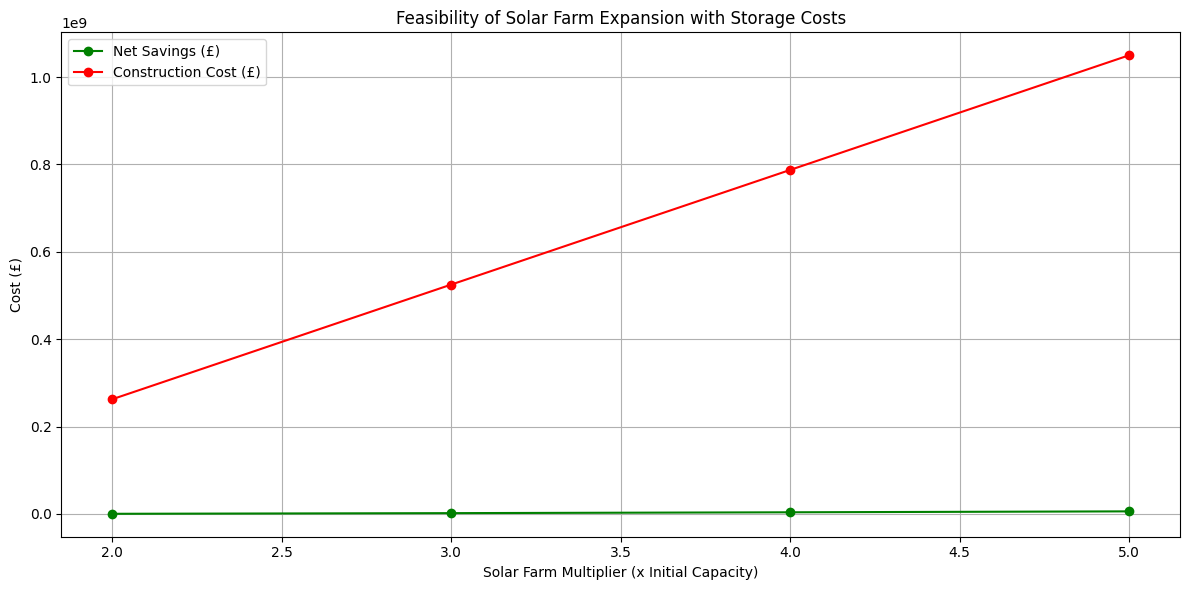

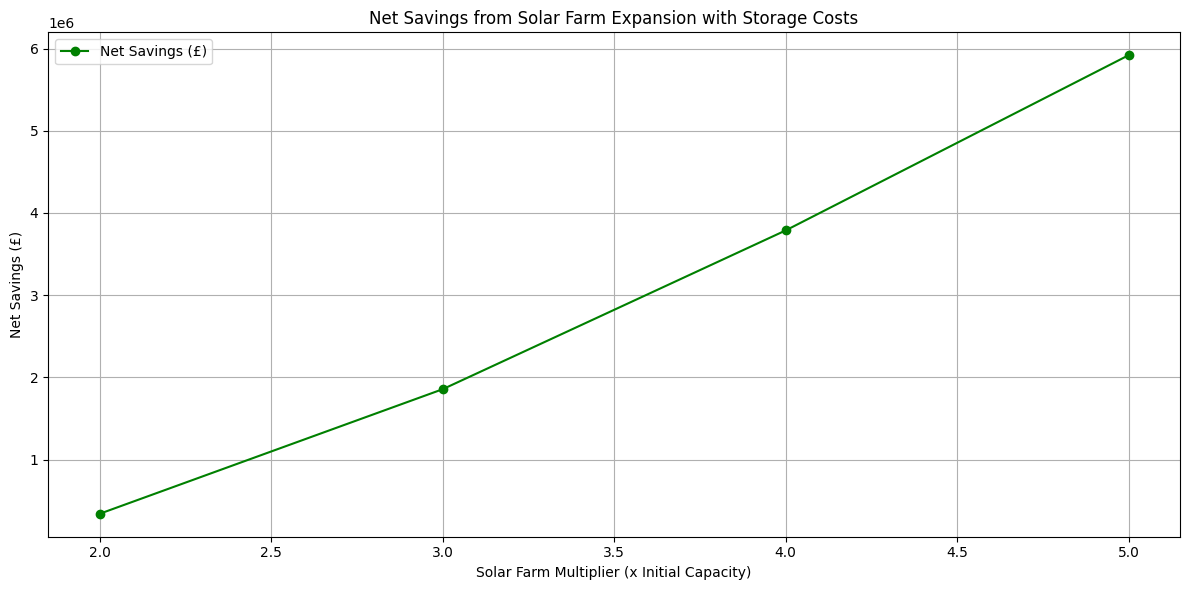

Net Savings (adjusted for storage costs): [341815.0201404864, 1856496.298618074, 3787413.9269218743, 5918197.831756603]
Battery Storage Costs: [547727.6828757193, 2974867.5628458294, 6068988.581694089, 9483377.248477448]
Construction Costs: [262500000, 525000000, 787500000, 1050000000]


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# INPUT DATA
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)
hours = node_demands.shape[0]
total_demand = np.sum(node_demands.values, axis=1)  # Total demand for each hour

# Initial generator capacities
initial_solar_capacity = 350  # MW
wind_capacity = 350  # MW
gen_capacities = [wind_capacity, initial_solar_capacity]

# Marginal cost of coal/gas generation (approximation)
fossil_fuel_marginal_cost = 216  # £/MWh

# Battery storage cost (mid-range estimate)
battery_cost_per_mwh = 133  # £/kWh (or £300,000 per MWh for battery capacity)

# Solar and Wind Availability
time = np.arange(hours)
solar_availability = 0.5 * (1 + np.sin(2 * np.pi * time / 24 - np.pi / 2))
solar_availability = np.clip(solar_availability, 0, 1)

np.random.seed(42)
shape, scale = 2.3, 9.5
wind_availability = np.random.weibull(shape, hours) * scale
max_possible_speed = scale * 1.5
wind_availability = np.clip(wind_availability / max_possible_speed, 0.4, 1.0)

# Expansion levels (starting at 2x)
expansion_levels = range(2, 6)  # Doubling, tripling, etc., up to 5x initial capacity
construction_cost_per_mw = 750_000  # £750,000 per MW
savings = []
construction_costs = []
battery_costs = []

for multiplier in expansion_levels:
    # Updated solar capacity
    solar_capacity = initial_solar_capacity * multiplier
    gen_capacities[1] = solar_capacity
    
    # Renewable generation
    wind_generation = wind_capacity * wind_availability
    solar_generation = solar_capacity * solar_availability
    total_renewable_generation = wind_generation + solar_generation
    
    # Surplus energy
    surplus_energy = np.maximum(total_renewable_generation - total_demand, 0)  # Surplus in MW
    total_surplus_energy_mwh = np.sum(surplus_energy)  # Convert to MWh for the week
    
    # Debug surplus calculation
    print(f"Multiplier: {multiplier}")
    print(f"Total Renewable Generation: {np.sum(total_renewable_generation):.2f} MW")
    print(f"Total Demand: {np.sum(total_demand):.2f} MW")
    print(f"Surplus Energy (MWh): {total_surplus_energy_mwh:.2f}")
    
    # Savings from surplus energy
    surplus_savings = total_surplus_energy_mwh * fossil_fuel_marginal_cost
    
    # Cost of storing surplus energy in a battery
    storage_cost = total_surplus_energy_mwh * battery_cost_per_mwh
    
    # Adjust savings by subtracting storage cost
    net_savings = surplus_savings - storage_cost
    savings.append(net_savings)
    
    # Battery cost tracking
    battery_costs.append(storage_cost)
    
    # Construction cost for the solar farm (incremental cost)
    additional_farms = multiplier - 1  # Number of new farms added beyond the base
    solar_construction_cost = additional_farms * initial_solar_capacity * construction_cost_per_mw
    construction_costs.append(solar_construction_cost)

# Plot Savings vs. Costs
plt.figure(figsize=(12, 6))
plt.plot(expansion_levels, savings, label="Net Savings (£)", marker="o", color="green")
plt.plot(expansion_levels, construction_costs, label="Construction Cost (£)", marker="o", color="red")
# plt.axvline(
#     x=expansion_levels[np.argmax(np.array(savings) >= np.array(construction_costs))],
#     color="blue",
#     linestyle="--",
#     label="Optimal Expansion Point",
# )
plt.xlabel("Solar Farm Multiplier (x Initial Capacity)")
plt.ylabel("Cost (£)")
plt.title("Feasibility of Solar Farm Expansion with Storage Costs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Savings Only
plt.figure(figsize=(12, 6))
plt.plot(expansion_levels, savings, label="Net Savings (£)", marker="o", color="green")
plt.xlabel("Solar Farm Multiplier (x Initial Capacity)")
plt.ylabel("Net Savings (£)")
plt.title("Net Savings from Solar Farm Expansion with Storage Costs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Net Savings (adjusted for storage costs):", savings)
print("Battery Storage Costs:", battery_costs)
print("Construction Costs:", construction_costs)




## looking at longer time period 

In [23]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Given data from previous analysis
# solar_multipliers = [1, 2, 3, 4, 5]
# construction_costs = [175_000_000, 350_000_000, 525_000_000, 700_000_000, 875_000_000]  # Cost in £
# savings_per_week = [1_000_000, 2_000_000, 2_500_000, 3_000_000, 3_500_000]  # Savings per week in £

# # Calculate breakeven weeks for each multiplier
# breakeven_weeks = [construction_costs[i] / savings_per_week[i] for i in range(len(solar_multipliers))]

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.plot(solar_multipliers, breakeven_weeks, marker='o', linestyle='-', color='purple', label="Breakeven Weeks")
# plt.axhline(y=52, color='blue', linestyle='--', label="1 Year (52 Weeks)")
# plt.axhline(y=260, color='green', linestyle='--', label="5 Years (260 Weeks)")
# plt.axhline(y=520, color='orange', linestyle='--', label="10 Years (520 Weeks)")

# # Labels and legend
# plt.xlabel("Solar Farm Multiplier (x Initial Capacity)")
# plt.ylabel("Weeks to Breakeven")
# plt.title("Weeks to Breakeven for Solar Farm Expansion")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


Breakeven weeks calculated (excluding first value): [511.97282064455436, 188.52717361221275, 138.61701153606958, 118.2792498493127]


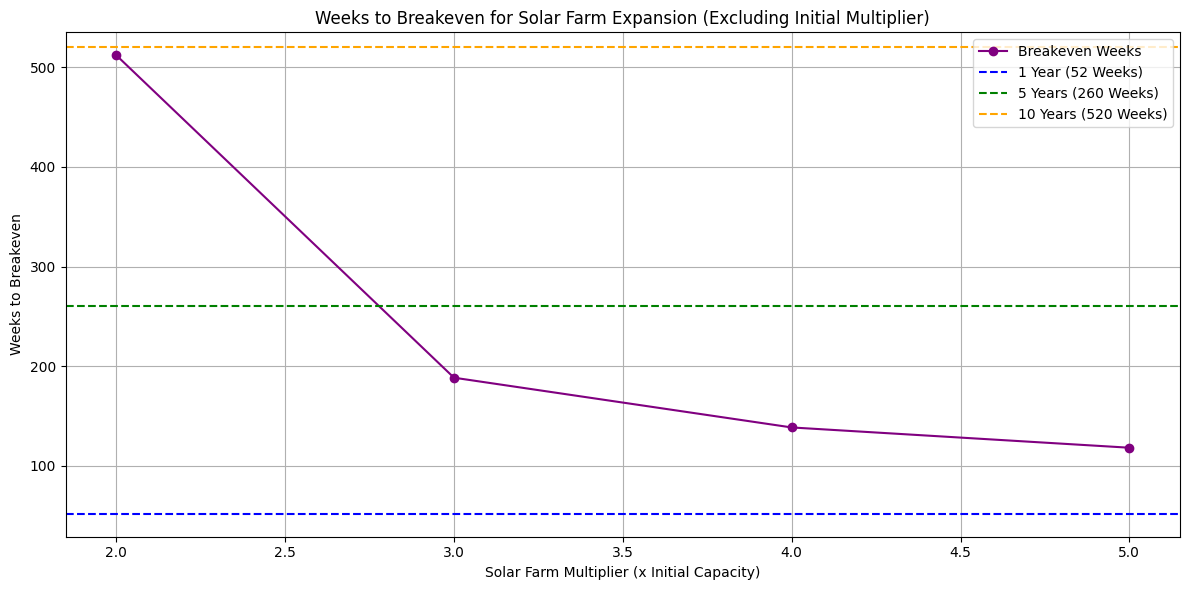

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Provided data (adjusted to use actual savings)
solar_multipliers = [2, 3, 4, 5]
construction_costs = [175_000_000, 350_000_000, 525_000_000, 700_000_000]  # £
# Replace these values with your calculated savings
weekly_savings = savings  # Use actual savings from the simulation

# Exclude the first multiplier from both lists
solar_multipliers_excluded = solar_multipliers[0:]
construction_costs_excluded = construction_costs[0:]
weekly_savings_excluded = weekly_savings[0:]

# Calculate breakeven weeks excluding the first value
breakeven_weeks_excluded = []
for i in range(len(solar_multipliers_excluded)):
    if weekly_savings_excluded[i] > 0:
        breakeven_weeks_excluded.append(construction_costs_excluded[i] / weekly_savings_excluded[i])
    else:
        breakeven_weeks_excluded.append(float('inf'))  # Handle division by zero case

# Debug breakeven weeks
print("Breakeven weeks calculated (excluding first value):", breakeven_weeks_excluded)

# Plotting Breakeven Weeks
plt.figure(figsize=(12, 6))
plt.plot(solar_multipliers_excluded, breakeven_weeks_excluded, marker='o', linestyle='-', color='purple', label="Breakeven Weeks")
plt.axhline(y=52, color='blue', linestyle='--', label="1 Year (52 Weeks)")
plt.axhline(y=260, color='green', linestyle='--', label="5 Years (260 Weeks)")
plt.axhline(y=520, color='orange', linestyle='--', label="10 Years (520 Weeks)")

# Labels and legend
plt.xlabel("Solar Farm Multiplier (x Initial Capacity)")
plt.ylabel("Weeks to Breakeven")
plt.title("Weeks to Breakeven for Solar Farm Expansion (Excluding Initial Multiplier)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

